# Align motion recordings with tapping synch cue
From the concatonated MusicLab App motion data files, we can use participants tapping to the synchronisation cues to align their device recordings to the concert events. This alignment process is especially important for the remote participants, as their views of the concert was necessarily delayed by many seconds, an interval of time dependent on where they were watching from. 

This notebook gives an example of how the alignment process, comparing a template tapping cue to a device motion recording, and then refers to a file of shifts that were generated with the notebook Alignment correction.ipynd with supervision. 

An example manipulation of the resultant datafiles with concert timing is then presented below, with devices gathered in their new alignment, interpolated into a dataframe, and plotted as a set. 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

## Some essential functions

In [2]:
def nannotime(row,shift,dshift):
    # function to generate a row of nans with caveats for time fields, which are shifted by a designated ammount 
    r = row.copy()
    cols = r.index
    for c in cols:
        if not c.startswith('time'):
            if not c.startswith('datetime'):
                r[c] = np.nan
            if c.startswith('datetime'):
                r[c] = r[c] + dshift  
        if c.startswith('time'):
            r[c] = r[c] + shift     
    return r

def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    
    data = data.append(nannotime(data.iloc[-1,:],deltat,dtdeltat),ignore_index=True)
    
    dt = data[time_col].diff()
    a = list(dt[dt>gap_t].index)
    a.sort(reverse=True)
    for gapi in a:
        data = data.append(nannotime(data.iloc[gapi-1,:],deltat,dtdeltat))
        data = data.append(nannotime(data.iloc[gapi,:],-deltat,dtdeltat))

    data = data.append(nannotime(data.iloc[0,:],-1,dtdeltat)).sort_values(time_col,ignore_index=True)
    return data

# Realignment with tapping cue
Most mobiles with a decent amount of data included at least one synchronisation tapping cue. This loads the tapping cue to demonstrate how alignment is acheived and then uses supervised alignment corrections generated elsewhere to generate files with concert/stimulus time.

### initialise concert timed events

In [41]:
time_data_folder = 'C:/Users/finnu/dev/MobileMotion_MusicLab/timing/'

In [156]:
ts_dt[54300]

Timestamp('2021-10-26 19:00:30', freq='100L')

In [159]:
concert_times = pd.read_csv(time_data_folder + 'concert_events.csv',",") #SV alignment for beeps
concert_times['S_AudioTime'] = 2*np.round(concert_times["TIME"]/2,2) # reset to 50 hz
concert_times['event'] = concert_times["LABEL"]

concert_times['CTime'] = concert_times['S_AudioTime']-concert_times.loc[38,'S_AudioTime'] # zero on onset of first synch cue
concert_times['StimTime'] = pd.to_timedelta(concert_times['CTime'],unit = 's')
concert_times['ConcertdTime'] = concert_times['StimTime'] + pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)

concert_times['time_concert'] = concert_times['CTime']*1000
concert_times=concert_times.set_index('ConcertdTime', drop=True)
concert_times

,TIME,LABEL,S_AudioTime,event,CTime,StimTime,time_concert
ConcertdTime,,,,,,,
2021-10-26 17:36:34.760,946.00,Claps on,946.00,Claps on,-691.24,-1 days +23:48:28.760000,-691240.0
2021-10-26 17:36:51.880,963.13,Claps off,963.12,Claps off,-674.12,-1 days +23:48:45.880000,-674120.0
2021-10-26 17:36:52.880,964.11,Speach Danish,964.12,Speach Danish,-673.12,-1 days +23:48:46.880000,-673120.0
2021-10-26 17:37:09.880,981.12,Speach English,981.12,Speach English,-656.12,-1 days +23:49:03.880000,-656120.0
2021-10-26 17:37:20.400,991.64,Speach Danish,991.64,Speach Danish,-645.60,-1 days +23:49:14.400000,-645600.0
...,...,...,...,...,...,...,...
2021-10-26 20:02:08.240,9679.49,Claps on,9679.48,Claps on,8042.24,0 days 02:14:02.240000,8042240.0
2021-10-26 20:02:30.040,9701.27,Claps iso,9701.28,Claps iso,8064.04,0 days 02:14:24.040000,8064040.0
2021-10-26 20:03:55.280,9786.51,Claps off,9786.52,Claps off,8149.28,0 days 02:15:49.280000,8149280.0


In [160]:
# draw up synchonised cue files
cues1=pd.read_csv(time_data_folder + 'synch1_cues.csv',index_col=0)
# cues1['time'] = 

cues1['time_concert'] = np.arange(0,180.02, 0.02)*1000 + -26000.0
cues1.index = pd.to_datetime(cues1.index)
cues2=pd.read_csv(time_data_folder + 'synch2_cues.csv',index_col=0)
cues2.index = pd.to_datetime(cues2.index)
cues2['time_concert'] = (np.arange(0,160.02, 0.02))*1000 -34280.0 + 5188280.0

cue_type = 'spointless'

In [161]:
concert_times.iloc[38,:]

TIME                    1637.23
LABEL             taps 60 bpm 1
S_AudioTime             1637.24
event             taps 60 bpm 1
CTime                       0.0
StimTime        0 days 00:00:00
time_concert                0.0
Name: 2021-10-26 17:48:06, dtype: object

In [162]:
synch1_time = concert_times.iloc[38,2]
synch1_datetime = concert_times.index[38]

In [164]:
# set the sampling period for the concert in UTC 
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

ts_dt = pd.date_range(Start_time,End_time, freq='20ms')
ts_ts = np.arange(Start_time.timestamp(),End_time.timestamp(), 0.02)*1000

In [165]:
sampleshift = cues1.index.to_series().diff().median()
sampleshift_s = sampleshift.total_seconds()
cue_type =  'spointless'

length1 = np.min([len(sec1_df),len(cues1)])
length2 = np.min([len(sec2_df),len(cues2)])

devs = sec1_df.columns # list of signals to consider
synch_offs = pd.DataFrame(index = devs, columns = ["s1_corr0","s1_corr_offset","s1_offset","s2_corr0","s2_corr_offset","s2_offset","devID"])

dev_n = 0

### example alignment evaluation with cues

In [166]:
folder ='C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Hall/deviceMotion/'
devices = os.listdir(folder)

In [172]:
aud_df = pd.DataFrame(index = ts_ts)
gap_t = 1000
dev_n = 0

devFile = devices[12]
print(devFile)

data = pd.read_csv(folder + '/' + devFile)
data['datetime'] = (pd.to_datetime(data['timestamp'],unit='ms'))
datas = gap_nans(data,gap_t)
datas['datetime'] = (pd.to_datetime(datas['timestamp'],unit='ms'))

resampled = pd.DataFrame(index = ts_dt[:-1])
cols = datas.columns
for col in cols[1:]:
    f = interpolate.interp1d(datas['timestamp'], datas[col],fill_value='extrapolate')
    resampled[col] = f(ts_ts)

b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
if np.nanmedian(b)>0:
    aud_df[dev_n] = b/np.nanmedian(b)
else:
    aud_df[dev_n] = b/np.nanmean(b)
kept_dev.append(devFile)

aud_df.index = ts_dt[:-1]

24ae5e42-8442-d093-94b9-7ed4f9daf5dd.Full_Concert.deviceMotion.csv


In [173]:
# pull out the section with the synchronisation cues

# first interval with synch cues
t_range1 = [ts_dt[53000],ts_dt[62000]]
sec1_df = aud_df.loc[t_range1[0]:t_range1[1],:]
# second interval with synch cues
t_range2 = [ts_dt[312000],ts_dt[320000]]
sec2_df = aud_df.loc[t_range2[0]:t_range2[1],:]

['0', 'spointless', 0.3333226148511317, -42, -0.84, 4001, 80.02]


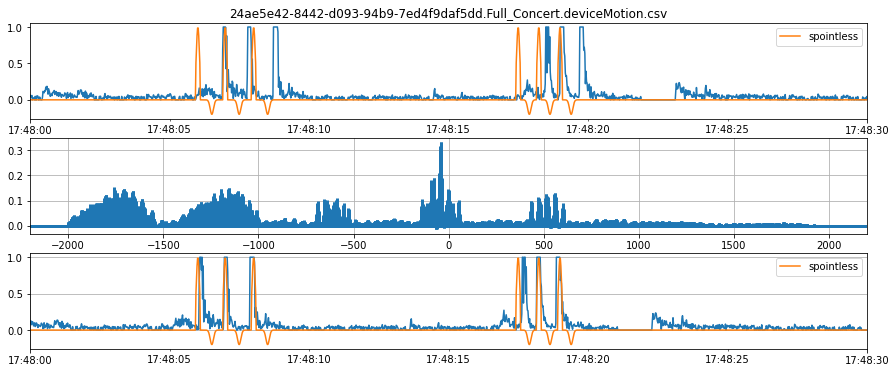

['0', 'spointless', 0.4365269973128594, -38, -0.76, 4001, 80.02]


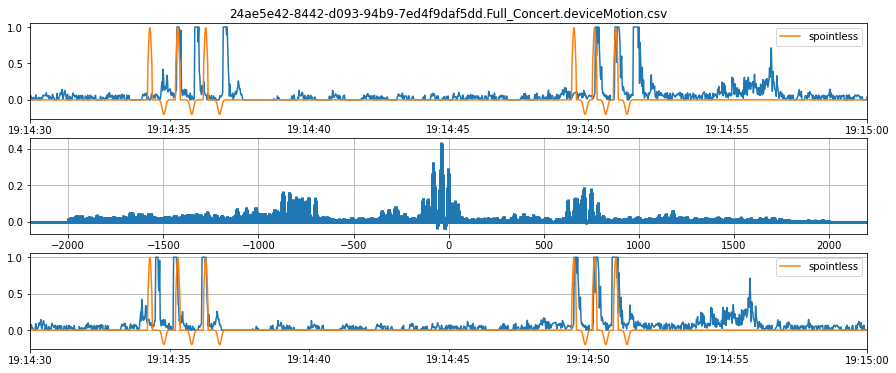

[-42, -38]


In [174]:
shifts = []    

# prep signal for synch 1
signal =sec1_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.995)
signal = signal/M
signal[signal>1] = 1

if signal.diff().abs().sum()<0.1: # signal is flat
    shifts.append(np.nan)
else: 
    # starting alignment between signal and cue
    fig = plt.figure(figsize=(15,6))
    ax1 = plt.subplot(311)
    signal.plot(ax=ax1)
    cues1.plot.line(y=cue_type,ax=ax1)
    plt.xlim([cues1.index[1000],cues1.index[2500]])
    plt.title(devFile)
    
    ax2 = plt.subplot(312)
    CCC = ax2.xcorr(cues1[cue_type].iloc[:length1], signal.iloc[:length1], usevlines=True, maxlags=np.min([length1-1,2000]), normed=True, lw=3)
    ax2.grid(True)
    shifts.append(CCC[0][np.argmax(CCC[1])])
    print([str(dev_n),cue_type, np.amax(CCC[1]),CCC[0][np.argmax(CCC[1])], (sampleshift_s*CCC[0][np.argmax(CCC[1])]), len(CCC[0]),len(CCC[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
    synch_offs.loc[dev_n,'s1_corr0'] = CCC[1][CCC[0]==0][0] # alignment quality without adjustment
    synch_offs.loc[dev_n,'s1_corr_offset'] =np.amax(CCC[1])
    synch_offs.loc[dev_n,'s1_offset'] = sampleshift_s*CCC[0][np.argmax(CCC[1])]

    signal.index = signal.index + pd.Timedelta(sampleshift_s*CCC[0][np.argmax(CCC[1])],'S')

    ax1 = plt.subplot(313)
    signal.plot(ax=ax1)
    cues1.plot.line(y=cue_type,ax=ax1)
    plt.xlim([cues1.index[1000],cues1.index[2500]])
    ax1.grid(True)
    #plt.saveas('')
    plt.show()
    #sigs[c] = signal
    CCC1 = CCC
# prep signal for synch 1
signal =sec2_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.995)
signal = signal/M
signal[signal>1] = 1

if signal.diff().abs().sum()<0.1: # signal is flat
    shifts.append(np.nan)
else: 
    # starting alignment between signal and cue
    fig = plt.figure(figsize=(15,6))
    ax1 = plt.subplot(311)
    signal.plot(ax=ax1)
    cues2.plot.line(y=cue_type,ax=ax1)
    plt.xlim([cues2.index[1500],cues2.index[3000]])
    plt.title(devFile)

    ax2 = plt.subplot(312)
    CCC = ax2.xcorr(cues2[cue_type].iloc[:length2], signal.iloc[:length2], usevlines=True, maxlags=np.min([length2-1,2000]), normed=True, lw=3)
    ax2.grid(True)
    shifts.append(CCC[0][np.argmax(CCC[1])])
    #xc = np.correlate(signal.iloc[:length],cues[C2].iloc[:length], "full")
    print([str(dev_n),cue_type, np.amax(CCC[1]),CCC[0][np.argmax(CCC[1])], (sampleshift_s*CCC[0][np.argmax(CCC[1])]), len(CCC[0]),len(CCC[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
    synch_offs.loc[dev_n,'s2_corr0'] = CCC[1][CCC[0]==0][0] # alignment quality without adjustment
    synch_offs.loc[dev_n,'s2_corr_offset'] =np.amax(CCC[1])
    synch_offs.loc[dev_n,'s2_offset'] = sampleshift_s*CCC[0][np.argmax(CCC[1])]

    signal.index = signal.index + pd.Timedelta(sampleshift_s*CCC[0][np.argmax(CCC[1])],'S')

    ax1 = plt.subplot(313)
    signal.plot(ax=ax1)
    cues2.plot.line(y=cue_type,ax=ax1)
    plt.xlim([cues2.index[1500],cues2.index[3000]])
    ax1.grid(True)
    #plt.saveas('')
    plt.show()
    #sigs[c] = signal
    CCC2 = CCC
    
synch_offs.loc[dev_n,'devID'] = kept_dev[dev_n]
print(shifts)

This shows high quality tapping capture. Not all mobiles were as reliable. See notebook AlignmentCorrection for more details on cue quality and realignment confidence.

## Generate Concert Aligned timing files, Hall devices
load supervised realignement values and output new files

In [169]:
Synchs = pd.read_csv(time_data_folder + 'Hall_synchs_8sample.csv',index_col = 0)
synchalignments = Synchs.drop([58,61, 77]).reset_index(drop = True) # recordings with no synch cues
synchalignments.loc[70:]

,s1_corr0,s1_corr_offset,s1_offset,s2_corr0,s2_corr_offset,s2_offset,devID
70,0.324862,0.345788,-0.02,0.360521,0.456169,0.06,e0f25cee-1127-b60a-4e29-c275c1358aaa.Full_Conc...
71,0.137778,0.148627,0.04,0.059795,0.203467,0.22,e95e41d4-b20c-560b-85df-6c815f20bc49.Full_Conc...
72,0.204297,0.276919,0.08,0.131349,0.430839,0.26,f03ce18b-d3d9-2639-d0b6-ebca90128a68.Full_Conc...
73,0.349501,0.380705,0.04,0.373903,0.393524,0.04,f045e08d-53b9-5e26-ad38-107564d919bc.Full_Conc...
74,0.275109,0.314279,0.06,0.174671,0.459556,0.18,f20847af-4c00-639e-5484-d705bd7a3437.Full_Conc...
75,0.167116,0.331279,0.12,-0.020349,0.391543,0.36,f9945bf5-e47a-a404-3f45-d6954e78ce2a.Full_Conc...
76,0.272865,0.287842,0.04,0.367610,0.450003,0.06,fe0534f2-aaad-2afb-f5ba-79f8c2cc98b2.Full_Conc...


In [170]:
input_folder ='C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Hall/deviceMotion'

output_folder ='C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Aligned/Hall'


In [171]:
for devN in range(len(synchalignments)):
    filename = synchalignments.loc[devN,'devID']
    devdets = filename.split('.')
    devID = devdets[0]
    a = synchalignments.loc[devN,:]
    print(a[['s1_offset','s2_offset','devID']])

    # plot corrected alignment
    data = pd.read_csv(input_folder + '/' + filename)
    data['datetime'] = (pd.to_datetime(data['timestamp'],unit='ms'))
    data['time'] = data['timestamp'] - synch1_datetime.timestamp()*1000
    # depending on the combination of cues available, use one or both to bring data into alignment
    if np.isnan(synchalignments.loc[devN,'s1_offset']):
        if np.isnan(synchalignments.loc[devN,'s2_offset']):
            data['time_concert'] = data['time']
            data['datetime_concert'] =  data['datetime'] # adjust remote participants by median offset?
        else:
            data['time_concert'] = data['time'] + (synchalignments.loc[devN,'s2_offset']*1000)
            data['datetime_concert'] = data['datetime']+ pd.to_timedelta(synchalignments.loc[devN,'s2_offset'],unit = 's')
    else:
        if np.isnan(synchalignments.loc[devN,'s2_offset']):
            data['time_concert'] = data['time'] + (synchalignments.loc[devN,'s1_offset']*1000)
            data['datetime_concert'] = data['datetime'] + pd.to_timedelta(synchalignments.loc[devN,'s1_offset'],unit = 's')
        else:
            data.loc[data['datetime']<=Mid_time,'time_concert'] = data.loc[data['datetime']<=Mid_time,'time'] + (synchalignments.loc[devN,'s1_offset']*1000)
            data.loc[data['datetime']>Mid_time,'time_concert'] = data.loc[data['datetime']>Mid_time,'time'] + synchalignments.loc[devN,'s2_offset']*1000

            data.loc[data['datetime']<=Mid_time,'datetime_concert'] =  data.loc[data['datetime']<=Mid_time,'datetime'] + pd.to_timedelta(synchalignments.loc[devN,'s1_offset'],unit = 's')
            data.loc[data['datetime']>Mid_time,'datetime_concert'] = data.loc[data['datetime']>Mid_time,'datetime'] + pd.to_timedelta(synchalignments.loc[devN,'s2_offset'],unit = 's')

    newdata = data.loc[:,['time_concert','datetime_concert','x','y','z','alpha','beta','gamma','timestamp']]
    newdata.to_csv(output_folder + '/' + filename, index = False)


s1_offset                                                 0.06
s2_offset                                                  0.1
devID        005093c6-7880-8728-1256-26822f05cfb0.Full_Conc...
Name: 0, dtype: object
s1_offset                                                 0.06
s2_offset                                                  0.1
devID        01393de0-e72e-5e80-f06f-8fdb5d0080cb.Full_Conc...
Name: 1, dtype: object
s1_offset                                                  0.0
s2_offset                                                 0.22
devID        01d00c32-d4dc-8ce6-353c-43143401adf3.Full_Conc...
Name: 2, dtype: object
s1_offset                                                 0.94
s2_offset                                                  NaN
devID        03fcbb15-14c6-b806-80b8-e2c161654dd6.Full_Conc...
Name: 3, dtype: object
s1_offset                                                 0.08
s2_offset                                                  0.0
devID        04e20480-91d3

s1_offset                                                 0.06
s2_offset                                                 0.02
devID        77d1745b-a57f-d560-8642-eb1060dd6e1a.Full_Conc...
Name: 39, dtype: object
s1_offset                                                 0.12
s2_offset                                                 0.14
devID        7a5ae780-d9a2-3236-6c5d-813fabdbca9a.Full_Conc...
Name: 40, dtype: object
s1_offset                                                  0.9
s2_offset                                                  NaN
devID        7aebf51e-258a-b204-b1eb-5512df8e8ff9.Full_Conc...
Name: 41, dtype: object
s1_offset                                                  0.1
s2_offset                                                 0.16
devID        7f95d7ef-2dae-67c7-090a-96c4873abb36.Full_Conc...
Name: 42, dtype: object
s1_offset                                                -0.18
s2_offset                                                 0.14
devID        83ee5aa4-

## Generate concert aligned files for Remote Audience

In [181]:
synchalignments = pd.read_csv(time_data_folder + 'Rem_synchs_8sample_alt.csv')
synchalignments

,s1_corr0,s1_corr_offset,s1_offset,s2_corr0,s2_corr_offset,s2_offset,devID
0,0.014027,0.322128,-11.64,0.022856,0.240564,-11.70,06fad321-8a49-062e-1e84-26704be216b8.Full_Conc...
1,0.023133,0.346800,-7.18,0.003891,NaN,NaN,09d8163d-80e7-fda3-6919-6a3febc78e27.Full_Conc...
2,NaN,NaN,NaN,0.002435,0.048423,-33.14,10550c8a-ad24-2550-6344-a0f8b85a4739.Full_Conc...
3,0.120968,0.279955,-9.34,NaN,NaN,NaN,1263f72c-512d-d97e-0fb1-561d37f92d7a.Full_Conc...
4,0.009746,0.207919,-32.74,NaN,NaN,NaN,201c5bcf-081c-b8a2-2be3-f62ee4d10c78.Full_Conc...
5,0.019590,0.634280,-13.96,NaN,NaN,NaN,214d0cc9-4279-d09c-77aa-ada046ae803f.Full_Conc...
6,0.012139,0.498135,-23.20,NaN,NaN,NaN,2d115485-bff7-ac99-1682-e3cb88d2f4de.Full_Conc...
7,0.016530,0.465905,-21.96,0.016593,0.417500,-21.70,34ac3d64-2d05-396e-a6ed-2ec90ba73dfd.Full_Conc...
8,0.025417,0.171119,-7.42,NaN,NaN,NaN,3bcb5d6e-b345-47a8-975d-ffcc14ba0a00.Full_Conc...
9,0.013503,0.296253,-7.28,NaN,NaN,NaN,3ee0563f-807c-89a7-0a65-71557f6a9775.Full_Conc...


In [182]:
input_folder ='C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Remote/deviceMotion'

output_folder ='C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Aligned/Remote'


In [183]:
for devN in range(len(synchalignments)):
    filename = synchalignments.loc[devN,'devID']
    devdets = filename.split('.')
    devID = devdets[0]
    a = synchalignments.loc[devN,:]
    print(a[['s1_offset','s2_offset','devID']])

    # plot corrected alignment
    data = pd.read_csv(input_folder + '/' + filename)
    data['datetime'] = (pd.to_datetime(data['timestamp'],unit='ms'))
    data['time'] = data['timestamp'] - synch1_datetime.timestamp()*1000
    # depending on the combination of cues available, use one or both to bring data into alignment
    if np.isnan(synchalignments.loc[devN,'s1_offset']):
        if np.isnan(synchalignments.loc[devN,'s2_offset']):
            data['time_concert'] = data['time']
            data['datetime_concert'] =  data['datetime'] # adjust remote participants by median offset?
        else:
            data['time_concert'] = data['time'] + (synchalignments.loc[devN,'s2_offset']*1000)
            data['datetime_concert'] = data['datetime']+ pd.to_timedelta(synchalignments.loc[devN,'s2_offset'],unit = 's')
    else:
        if np.isnan(synchalignments.loc[devN,'s2_offset']):
            data['time_concert'] = data['time'] + (synchalignments.loc[devN,'s1_offset']*1000)
            data['datetime_concert'] = data['datetime'] + pd.to_timedelta(synchalignments.loc[devN,'s1_offset'],unit = 's')
        else:
            data.loc[data['datetime']<=Mid_time,'time_concert'] = data.loc[data['datetime']<=Mid_time,'time'] + (synchalignments.loc[devN,'s1_offset']*1000)
            data.loc[data['datetime']>Mid_time,'time_concert'] = data.loc[data['datetime']>Mid_time,'time'] + synchalignments.loc[devN,'s2_offset']*1000

            data.loc[data['datetime']<=Mid_time,'datetime_concert'] =  data.loc[data['datetime']<=Mid_time,'datetime'] + pd.to_timedelta(synchalignments.loc[devN,'s1_offset'],unit = 's')
            data.loc[data['datetime']>Mid_time,'datetime_concert'] = data.loc[data['datetime']>Mid_time,'datetime'] + pd.to_timedelta(synchalignments.loc[devN,'s2_offset'],unit = 's')

    newdata = data.loc[:,['time_concert','datetime_concert','x','y','z','alpha','beta','gamma','timestamp']]
    newdata.to_csv(output_folder + '/' + filename, index = False)


s1_offset                                               -11.64
s2_offset                                                -11.7
devID        06fad321-8a49-062e-1e84-26704be216b8.Full_Conc...
Name: 0, dtype: object
s1_offset                                                -7.18
s2_offset                                                  NaN
devID        09d8163d-80e7-fda3-6919-6a3febc78e27.Full_Conc...
Name: 1, dtype: object
s1_offset                                                  NaN
s2_offset                                               -33.14
devID        10550c8a-ad24-2550-6344-a0f8b85a4739.Full_Conc...
Name: 2, dtype: object
s1_offset                                                -9.34
s2_offset                                                  NaN
devID        1263f72c-512d-d97e-0fb1-561d37f92d7a.Full_Conc...
Name: 3, dtype: object
s1_offset                                               -32.74
s2_offset                                                  NaN
devID        201c5bcf-081c

# Check on alignment of data WITH CORRECTION


In [196]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)
# device times 10 Hs
# ts_dt = pd.date_range(Start_time,End_time, freq='100ms')
# ts_ts = np.arange(Start_time.timestamp(),End_time.timestamp(), 0.1)*1000
# concert times 10 Hz
ts_ct = np.arange(-200,9800, 0.1)*1000 
dt_ct = Start_time + pd.to_timedelta(ts_ct,unit='ms')
[dt_ct[0],dt_ct[-1]]

[Timestamp('2021-10-26 17:26:40'), Timestamp('2021-10-26 20:13:19.899999999')]

In [197]:
concert_times = pd.read_csv(time_data_folder + 'concert_events.csv',",") #SV alignment for beeps
concert_times['S_AudioTime'] = 2*np.round(concert_times["TIME"]/2,2) # reset to 50 hz
concert_times['event'] = concert_times["LABEL"]

concert_times['CTime'] = concert_times['S_AudioTime']-concert_times.loc[38,'S_AudioTime'] # zero on onset of first synch cue
concert_times['StimTime'] = pd.to_timedelta(concert_times['CTime'],unit = 's')
concert_times['ConcertdTime'] = concert_times['StimTime'] + pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
concert_times['time_concert'] = concert_times['CTime']
concert_times=concert_times.set_index('ConcertdTime', drop=True)

In [198]:
# folder of devicewise files for a specific set
folder ='C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Aligned/Hall'
devices = os.listdir(folder)


In [199]:
# gather the aligned recordings for the live performance
aud_df = pd.DataFrame(index = ts_ct)
dev_n = 0
kept_dev = []
gap_t = 5000

for devFile in devices:
    if len(devFile)>10: # clearly an installation ID, not another folder
        print(devFile)
#         if not devFile.startswith('cc1ce8ab'):
        data = pd.read_csv(folder + '/' + devFile)
        data['datetime_concert'] = pd.to_datetime(data['datetime_concert'])
        datas = gap_nans(data,gap_t)
        resampled = pd.DataFrame(index = ts_ct)
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['time_concert'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ct)

        # extract 1D accelerometer feature for easy comparison
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            aud_df[dev_n] = b/np.nanmedian(b)
        else:
            aud_df[dev_n] = b/np.nanmean(b)
        dev_n+=1
        kept_dev.append(devFile)

005093c6-7880-8728-1256-26822f05cfb0.Full_Concert.deviceMotion.csv
01393de0-e72e-5e80-f06f-8fdb5d0080cb.Full_Concert.deviceMotion.csv
01d00c32-d4dc-8ce6-353c-43143401adf3.Full_Concert.deviceMotion.csv
03fcbb15-14c6-b806-80b8-e2c161654dd6.Full_Concert.deviceMotion.csv
04e20480-91d3-cd85-3470-8656b157978f.Full_Concert.deviceMotion.csv
053bd8a0-2ed7-46e9-c088-8eaea2448192.Full_Concert.deviceMotion.csv
0ab9bf2b-a0c7-f823-0fde-6295eedb207e.Full_Concert.deviceMotion.csv
195bb6e0-55ec-d521-d69e-7bfa7cf86b9a.Full_Concert.deviceMotion.csv
1a9a903b-9524-f8c2-a943-81a108880e46.Full_Concert.deviceMotion.csv
1f6cba0e-36f5-b0c4-8117-00e1608ad7c3.Full_Concert.deviceMotion.csv
20395f60-420d-ad45-5d8e-11674c5d174c.Full_Concert.deviceMotion.csv
21a7c459-6987-302c-0945-5e6d691a6bb9.Full_Concert.deviceMotion.csv
24ae5e42-8442-d093-94b9-7ed4f9daf5dd.Full_Concert.deviceMotion.csv
25decfa4-d6e0-d757-722e-0f9db423fc2d.Full_Concert.deviceMotion.csv
278e797b-f81d-27bc-0ab5-7763b027915a.Full_Concert.deviceMotion

In [200]:
aud_df.index = dt_ct

aud_df

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
2021-10-26 17:26:40.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 17:26:40.100000000,0.175477,1.550822,0.604865,NaN,4.513973,0.000000,2.635482,0.751986,1.146933,NaN,...,0.075463,0.580118,2.473004,1.400842,0.588207,0.280053,0.478236,1.494934,0.666992,1.048891
2021-10-26 17:26:40.200000000,0.652044,1.342476,1.612807,NaN,2.964014,0.074953,3.509344,0.801007,3.857173,NaN,...,0.075463,0.293411,2.082229,1.941709,0.837257,0.608416,0.410600,1.158174,1.620314,0.818999
2021-10-26 17:26:40.300000000,0.314276,1.057322,2.314423,NaN,6.199576,0.983209,3.003672,0.633406,3.445950,NaN,...,0.075463,0.351763,2.319472,1.535411,0.596731,0.196556,0.206922,0.490002,0.755731,0.875274
2021-10-26 17:26:40.400000000,1.372158,0.954908,1.609130,NaN,7.547812,0.159762,1.810873,1.172500,1.753799,NaN,...,0.075463,0.609129,3.377365,2.493424,1.156787,0.830701,0.510754,2.341939,1.088427,1.677502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26 20:13:19.499999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:13:19.599999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:13:19.699999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:13:19.799999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


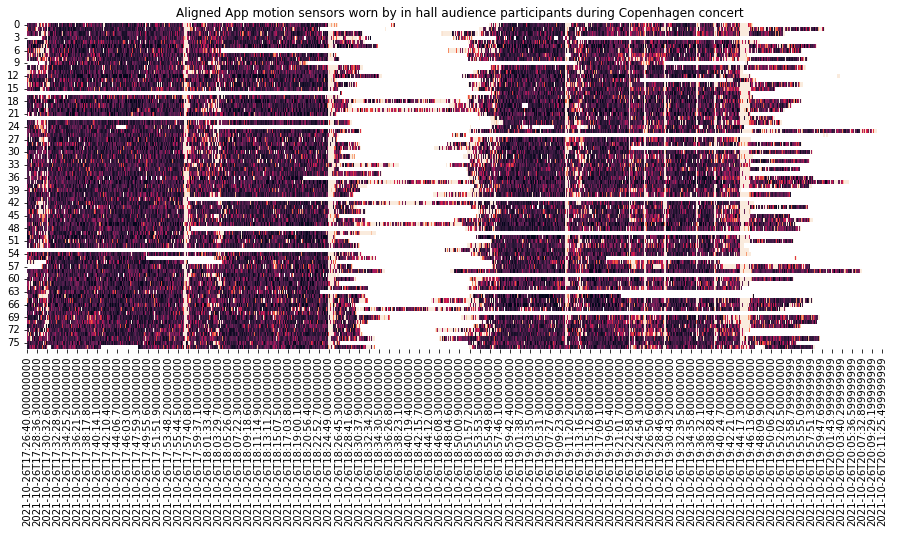

In [201]:
# plot for perspective
fig, ax = plt.subplots(figsize = [15.5,6])
chart = sns.heatmap(data=aud_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

# freq = int(round(len(aud_df)/len(ax.get_xticks())))
# ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
#plt.xticks(concert_times.index,concert_times.event, rotation='vertical')

plt.title('Aligned App motion sensors worn by in hall audience participants during Copenhagen concert')
plt.savefig('CoverageSnapshot_Copenhagen_Hall_Aligned.png')
plt.show()

In [188]:
# folder of devicewise files for a specific set
folder ='C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Aligned/Remote'
devices = os.listdir(folder)


In [189]:
# gather the aligned recordings for the live performance
aud_df = pd.DataFrame(index = ts_ct)
dev_n = 0
kept_dev = []
gap_t = 5000

for devFile in devices:
    if len(devFile)>10: # clearly an installation ID, not another folder
        print(devFile)
#         if not devFile.startswith('cc1ce8ab'):
        data = pd.read_csv(folder + '/' + devFile)
        data['datetime_concert'] = pd.to_datetime(data['datetime_concert'])
        datas = gap_nans(data,gap_t)
        resampled = pd.DataFrame(index = ts_ct)
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['time_concert'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ct)

        # extract 1D accelerometer feature for easy comparison
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            aud_df[dev_n] = b/np.nanmedian(b)
        else:
            aud_df[dev_n] = b/np.nanmean(b)
        dev_n+=1
        kept_dev.append(devFile)

06fad321-8a49-062e-1e84-26704be216b8.Full_Concert.deviceMotion.csv
09d8163d-80e7-fda3-6919-6a3febc78e27.Full_Concert.deviceMotion.csv
10550c8a-ad24-2550-6344-a0f8b85a4739.Full_Concert.deviceMotion.csv
1263f72c-512d-d97e-0fb1-561d37f92d7a.Full_Concert.deviceMotion.csv
201c5bcf-081c-b8a2-2be3-f62ee4d10c78.Full_Concert.deviceMotion.csv
214d0cc9-4279-d09c-77aa-ada046ae803f.Full_Concert.deviceMotion.csv
2d115485-bff7-ac99-1682-e3cb88d2f4de.Full_Concert.deviceMotion.csv
34ac3d64-2d05-396e-a6ed-2ec90ba73dfd.Full_Concert.deviceMotion.csv
3bcb5d6e-b345-47a8-975d-ffcc14ba0a00.Full_Concert.deviceMotion.csv
3ee0563f-807c-89a7-0a65-71557f6a9775.Full_Concert.deviceMotion.csv
4120c5ac-063e-a105-45b3-812340ad7273.Full_Concert.deviceMotion.csv
49d38fe8-2daf-4dc0-8297-5a872da374fb.Full_Concert.deviceMotion.csv
4b23fcfc-a2bd-ec20-203c-fd0e6125f070.Full_Concert.deviceMotion.csv
4deab979-564b-2a7d-8263-ffe4ee4d097e.Full_Concert.deviceMotion.csv
689d4b0e-6e58-049a-5329-e448a3011643.Full_Concert.deviceMotion

In [190]:
aud_df.index = dt_ct

aud_df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
2021-10-26 17:26:40.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 17:26:40.100000000,0.882353,3.002583,NaN,NaN,NaN,NaN,0.546707,28.510805,NaN,0.902908,...,0.419345,NaN,NaN,NaN,NaN,NaN,2.017478,1.270198,NaN,NaN
2021-10-26 17:26:40.200000000,0.166378,4.525235,NaN,NaN,NaN,NaN,0.978002,32.404907,NaN,0.902908,...,0.563127,NaN,NaN,NaN,NaN,NaN,2.229524,1.076363,NaN,NaN
2021-10-26 17:26:40.300000000,1.209190,8.160873,NaN,NaN,NaN,NaN,0.707837,60.758665,NaN,0.913398,...,0.470423,NaN,NaN,NaN,NaN,NaN,1.722367,1.549293,NaN,NaN
2021-10-26 17:26:40.400000000,1.292487,3.660613,NaN,NaN,NaN,NaN,1.002497,28.359355,NaN,1.225452,...,0.489849,NaN,NaN,NaN,NaN,NaN,0.957420,2.163426,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26 20:16:39.499999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:16:39.599999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:16:39.699999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:16:39.799999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


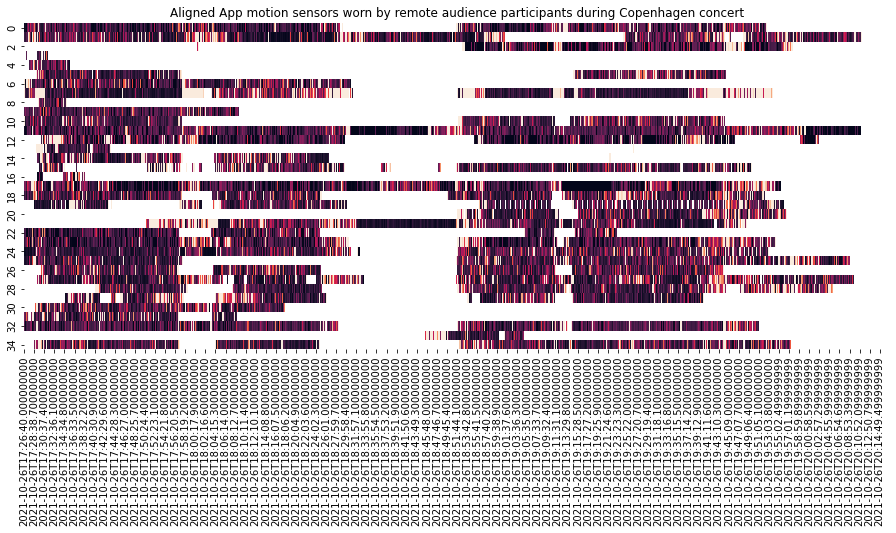

In [191]:
# plot for perspective
fig, ax = plt.subplots(figsize = [15.5,6])
chart = sns.heatmap(data=aud_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

# freq = int(round(len(aud_df)/len(ax.get_xticks())))
# ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
#plt.xticks(concert_times.index,concert_times.event, rotation='vertical')

plt.title('Aligned App motion sensors worn by remote audience participants during Copenhagen concert')
plt.savefig('CoverageSnapshot_Copenhagen_Remote_Aligned.png')
plt.show()